In [1]:
# Modeling
import pandas as pd
import numpy as np
import nltk
import torch
from sklearn.model_selection import train_test_split

# NLP-related
from string import punctuation
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv("advanced_trainset.csv")
test = pd.read_csv("advanced_testset.csv")

In [3]:
train.head()

,Sentence,Sentiment
0,According to the Finnish-Russian Chamber of Co...,neutral
1,The Swedish buyout firm has sold its remaining...,neutral
2,$SPY wouldn't be surprised to see a green close,positive
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative


## Data Preprocessing

In [223]:
# Encoder
def label_encode(labels):
    arr = []
    for label in labels:
        if label == 'positive':
            arr.append([1, 0, 0])
        elif label == 'negative':
            arr.append([0, 0, 1])
        else:
            arr.append([0, 1, 0])
    return arr

In [224]:
labels = label_encode(train.Sentiment)

In [225]:
# Vocabulary
nltk.download('stopwords')
import re
stops = set(stopwords.words('english'))
# special cases
stops.add("'s")
stops.add("``")
stops.add("--")

stops.remove('not')
stops.remove('against')
from nltk.tokenize import word_tokenize
# 去掉stopwords和punctuations
def clean_all(lst):
    sens = []
    for sentence in lst:
        cleaned = clean(sentence)
        sens.append(cleaned)
    return sens

def clean(sentence):
    # delete stopwords
    temp = " ".join(filter(lambda x: x not in stops, sentence.split()))
    # Remove punctuation
    temp = temp.translate(str.maketrans('', '', punctuation))
    # Delete short words with 3 or less characters
    temp = (lambda x: ' '.join([w for w in x.split() if len(w) > 3]))(temp)
    # Change all to lower case
    temp = temp.lower()
    # Delete numbers
    temp = re.sub(r'[0-9]', "", temp)
    # Delete excessive spaces and return
    return re.sub("  ", " ", temp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liuhn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [226]:
from collections import defaultdict
nltk.download('punkt')
def vocab(lst):
    cleaned = clean_all(lst)
    counter = defaultdict(int)
    for sentence in cleaned:
        for word in sentence.split():
            counter[word] += 1
    return dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liuhn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [227]:
vocabulary = vocab(train.Sentence)

In [228]:
len(vocabulary)

8494

In [229]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
tfidf_vectorizer = TfidfVectorizer(max_features = 20, max_df = 20000, ngram_range = (1, 1), tokenizer = token.tokenize)
tfidf = tfidf_vectorizer.fit_transform(train['Sentence'])

In [230]:
tfidf

<4382x20 sparse matrix of type '<class 'numpy.float64'>'
	with 18113 stored elements in Compressed Sparse Row format>

In [231]:
new_lengths = []
for s in clean_all(train.Sentence):
    new_lengths.append(len(s.split(' ')))

In [234]:
max(new_lengths)

33

## Based on the median, we decide the threshold to be 10

In [235]:
# Get features
threshold = 33
pad = '<pad>'
cleaned = clean_all(train.Sentence)
features = []
for s in cleaned:
    lst = s.split()
    counts = []
    for w in lst:
        counts.append((vocabulary[w], w))
    counts.sort(reverse=True)
    if len(lst) > threshold:
        new = [pair[0] for pair in counts[:threshold]]
        features.append(new)
    else:
        features.append((threshold-len(lst))*[0]+[i[0] for i in counts])

In [236]:
def accuracy(preds, y):
    correct = (torch.round(torch.sigmoid(preds)) == y).float() 
    return correct.sum() / len(correct)

In [271]:
def min_max_normalize(data):
    new = []
    for i in data:
        maxi = max(i) if len(i) != 0 else 0
        mini = min(i) if len(i) != 0 else 0
        lst = []
        for elem in i:
            if maxi - mini != 0:
                lst.append((elem - mini) / (maxi - mini))
            else:
                lst.append(0)
        new.append(lst)
    return new

In [238]:
from keras.models import Model
from keras.preprocessing import sequence
from keras.layers import Input
from keras.layers import Dense, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

In [295]:
# another features
idxs = range(1, len(vocabulary)+1)
mapping = dict(zip(vocabulary.keys(), idxs))
features_new = []
for sentence in cleaned:
    tmp = []
    words = sentence.split()
    for w in words:
        tmp.append(mapping[w])
    features_new.append(tmp)

In [305]:
# Encoder
def encode(labels):
    arr = []
    for label in labels:
        if label == 'positive':
            arr.append(1)
        elif label == 'negative':
            arr.append(-1)
        else:
            arr.append(0)
    return arr

In [312]:
# set parameters:
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 5
epochs = 5

# load the dataset but only keep the top n words, zero the rest
# features = min_max_normalize(features)
top_words = 500
x_train, x_test, y_train, y_test = train_test_split(features_new, encode(train.Sentiment), test_size=0.2)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# pad dataset to a maximum review length in words
max_words = 33
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

# Build baseline model
sentence = Input(batch_shape=(None, max_words), dtype='int32', name='sentence')
embedding_layer = Embedding(len(vocabulary)+1, embedding_dims, input_length=max_words)
sent_embed = embedding_layer(sentence)
conv_layer = Conv1D(filters, kernel_size, padding='valid', activation='tanh')
sent_conv = conv_layer(sent_embed)
sent_pooling = GlobalMaxPooling1D()(sent_conv)
sent_repre = Dense(100)(sent_pooling)
sent_repre = Activation('relu')(sent_repre)
sent_repre = Dense(1)(sent_repre)
pred = Activation('softmax')(sent_repre)
model = Model(inputs=sentence, outputs=pred)
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history = model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, verbose=1,validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/1178606672.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/1178606672.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


Epoch 1/5
110/110 [==============================] - 3s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3147
Epoch 2/5
110/110 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3147
Epoch 3/5
110/110 [==============================] - 2s 19ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3147
Epoch 4/5
110/110 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3147
Epoch 5/5
110/110 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3147
Accuracy: 31.47%


In [316]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

In [261]:
max([len(i) for i in features_new])

33

In [262]:
min([len(i.split()) for i in cleaned])

0

In [264]:
len(vocabulary)

8494

In [318]:
# set parameters:
batch_size = 32
embedding_dims = 5000
filters = 250
kernel_size = 5
epochs = 10

# load the dataset but only keep the top n words, zero the rest
# features_new = min_max_normalize(features_new)
top_words = 500
x_train, x_test, y_train, y_test = train_test_split(features_new, label_encode(train.Sentiment), test_size=0.2)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# pad dataset to a maximum review length in words
max_words = 20
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

model = Sequential()
model.add(layers.Embedding(len(vocabulary)+1, 15))
model.add(layers.SimpleRNN(15,return_sequences=True))
model.add(Dropout(0.3))
model.add(layers.SimpleRNN(15))
model.add(layers.Dense(3,activation='softmax', kernel_regularizer='l2'))

# model = Model(inputs=sentence, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history = model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, verbose=1,validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/2366939475.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/2366939475.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


Epoch 1/10
110/110 [==============================] - 3s 11ms/step - loss: 1.0387 - accuracy: 0.5221 - val_loss: 1.0158 - val_accuracy: 0.5393
Epoch 2/10
110/110 [==============================] - 1s 8ms/step - loss: 0.9491 - accuracy: 0.5683 - val_loss: 1.0212 - val_accuracy: 0.5302
Epoch 3/10
110/110 [==============================] - 1s 8ms/step - loss: 0.7439 - accuracy: 0.7170 - val_loss: 1.1037 - val_accuracy: 0.4926
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 0.4886 - accuracy: 0.8394 - val_loss: 1.2617 - val_accuracy: 0.4755
Epoch 5/10
110/110 [==============================] - 1s 8ms/step - loss: 0.3577 - accuracy: 0.8813 - val_loss: 1.3838 - val_accuracy: 0.4652
Epoch 6/10
110/110 [==============================] - 1s 8ms/step - loss: 0.2924 - accuracy: 0.9016 - val_loss: 1.4403 - val_accuracy: 0.4664
Epoch 7/10
110/110 [==============================] - 1s 9ms/step - loss: 0.2625 - accuracy: 0.9093 - val_loss: 1.5705 - val_accuracy: 0.4709
Epoch

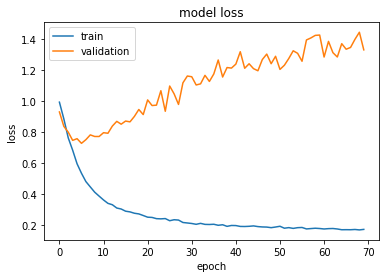

In [336]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

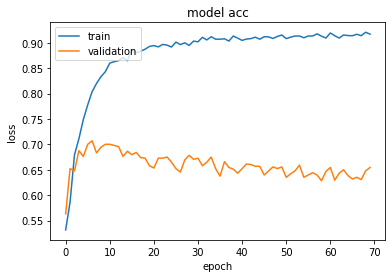

In [337]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [291]:
num = 0
for i in y_test:
    if list(i) == [0, 1, 0]:
        num += 1

In [285]:
model.predict(x_test)

array([[0.33307016, 0.53701854, 0.12991126],
       [0.3116378 , 0.575107  , 0.11325519],
       [0.358759  , 0.49605244, 0.14518848],
       ...,
       [0.33202416, 0.53936845, 0.12860735],
       [0.31244716, 0.5570241 , 0.13052869],
       [0.33842158, 0.4919063 , 0.16967215]], dtype=float32)

In [360]:
# set parameters:
batch_size = 32
embedding_dims = 500
filters = 250
kernel_size = 5
epochs = 70

# load the dataset but only keep the top n words, zero the rest
# features_new = min_max_normalize(features_new)
top_words = 500
x_train, x_test, y_train, y_test = train_test_split(features_new, label_encode(train.Sentiment), test_size=0.2)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# pad dataset to a maximum review length in words
max_words = 20
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

model2 = Sequential()
model2.add(layers.Embedding(len(vocabulary)+1, 40, input_length=max_words))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.7)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model2.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[checkpoint2])

# model = Model(inputs=sentence, outputs=pred)
# model2.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# fit the model
history = model2.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, verbose=1,validation_data=(x_test, y_test), callbacks = [checkpoint2])
scores = model2.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/1813097056.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/1813097056.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


Epoch 1/70
106/110 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5442
Epoch 00001: val_accuracy improved from -inf to 0.50855, saving model to best_model2.hdf5
110/110 [==============================] - 5s 23ms/step - loss: 0.9852 - accuracy: 0.5461 - val_loss: 0.9797 - val_accuracy: 0.5086
Epoch 2/70
107/110 [============================>.] - ETA: 0s - loss: 0.8869 - accuracy: 0.5847
Epoch 00002: val_accuracy improved from 0.50855 to 0.59293, saving model to best_model2.hdf5
110/110 [==============================] - 1s 12ms/step - loss: 0.8850 - accuracy: 0.5869 - val_loss: 0.8845 - val_accuracy: 0.5929
Epoch 3/70
106/110 [===========================>..] - ETA: 0s - loss: 0.7733 - accuracy: 0.6683
Epoch 00003: val_accuracy improved from 0.59293 to 0.61574, saving model to best_model2.hdf5
110/110 [==============================] - 1s 12ms/step - loss: 0.7745 - accuracy: 0.6670 - val_loss: 0.8774 - val_accuracy: 0.6157
Epoch 4/70
106/110 [====================

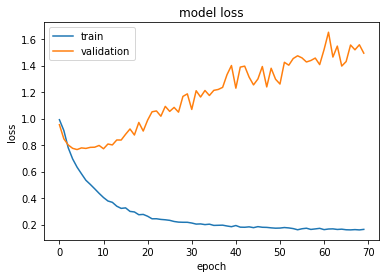

In [355]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

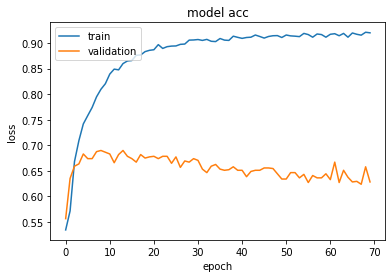

In [356]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [357]:
preds = model2.predict(x_test)
nums = [np.argmax(p) for p in preds]

In [358]:
labels = [np.argmax(k) for k in y_test]

In [359]:
sum(np.array(nums) == np.array(labels)) / len(nums)

0.6282782212086659

In [379]:
def convert_to_sentiment(lst):
    output = []
    for arr in lst:
        i = np.argmax(arr)
        if i == 0:
            output.append('positive')
        elif i == 1:
            output.append('negative')
        else:
            output.append('neutral')
    return output

In [364]:
# Process test data
test = pd.read_csv("advanced_testset.csv")
features_test = []
for i in clean_all(test.Sentence):
    features_test.append(i.strip())

In [369]:
# another features
idxs = range(1, len(vocabulary)+1)
mapping = dict(zip(vocabulary.keys(), idxs))
features_togo = []
for sentence in features_test:
    tmp = []
    words = sentence.split()
    for w in words:
        if w in mapping:
            tmp.append(mapping[w])
        else:
            tmp.append(0)
    features_togo.append(tmp)

In [372]:
x_togo = np.array(features_togo)

C:\Users\liuhn\AppData\Local\Temp/ipykernel_49780/2490767889.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_togo = np.array(features_togo)


In [389]:
x_togo = sequence.pad_sequences(features_togo, maxlen=max_words)
final = convert_to_sentiment(model2.predict(x_togo))
df = pd.DataFrame(final, columns = ['Sentiment'])
df.to_csv("prediction_datahack.csv", index = False)